In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [67]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
#plt.style.use('seaborn-paper')
# mpl.rcParams['font.family'] = 'serif'
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

C:\Users\carle\AppData\Local\Temp\ipykernel_3044\2692110022.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Is cuda available for GPU computing?

In [68]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


## 2. Load data

In [69]:
import yfinance as yf
data = yf.download('AMZN', period='2y', interval='1d')

[*********************100%***********************]  1 of 1 completed


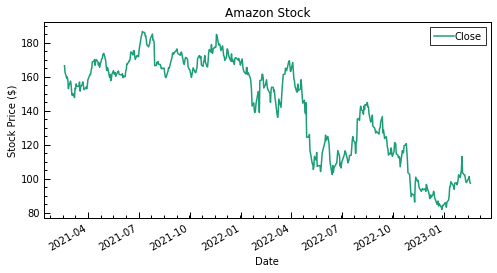

In [70]:
data[['Close']].plot(figsize=(8, 4))
plt.ylabel("Stock Price ($)")
plt.xlabel("Date")
plt.title("Amazon Stock")
plt.show()

In [71]:
close=data[['Close']]
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2021-02-18 to 2023-02-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   505 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [72]:
close=close.fillna(method='ffill')

# Normalize input values to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
close['Close'] = scaler.fit_transform(close['Close'].values.reshape(-1,1))

In [73]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

## 3. Build the structure of model

In [74]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [75]:
look_back = 250 # choose sequence length
x_train, y_train, x_test, y_test = load_data(close, look_back)

# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [76]:
# Build model
#####################
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
10


In [77]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.08116354048252106
Epoch  20 MSE:  0.03412608802318573
Epoch  30 MSE:  0.015553669072687626
Epoch  40 MSE:  0.010816089808940887
Epoch  50 MSE:  0.008990067057311535
Epoch  60 MSE:  0.007825656794011593
Epoch  70 MSE:  0.006922840140759945
Epoch  80 MSE:  0.0061975507996976376
Epoch  90 MSE:  0.005690038204193115
Epoch  100 MSE:  0.005372188054025173
Epoch  110 MSE:  0.0052167191170156
Epoch  120 MSE:  0.005406140815466642
Epoch  130 MSE:  0.005165334790945053
Epoch  140 MSE:  0.005186721682548523
Epoch  150 MSE:  0.005084810312837362
Epoch  160 MSE:  0.005021675489842892
Epoch  170 MSE:  0.004894176032394171
Epoch  180 MSE:  0.004782051779329777
Epoch  190 MSE:  0.004641867708414793


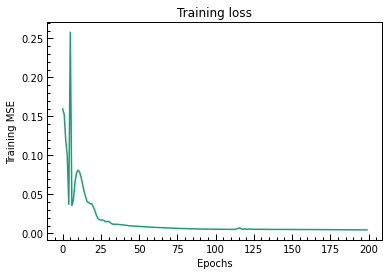

In [78]:
plt.figure()
plt.plot(hist, label="Training loss")
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
# plt.legend()
plt.savefig('trainingMse.png')
plt.show()

In [79]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.52 RMSE
Test Score: 2.77 RMSE


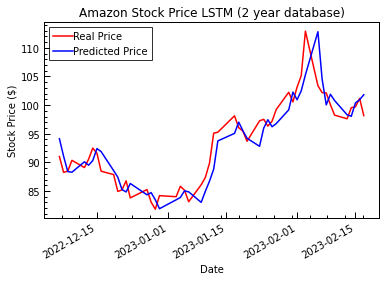

In [80]:
date_time = close[len(close)-len(y_test):].index

realValues = pd.DataFrame()
realValues['Real Price'] = y_test[:, 0]
realValues = realValues.set_index(date_time)
predictedValues = pd.DataFrame()
predictedValues['Predicted Price'] = y_test_pred[:, 0]
predictedValues = predictedValues.set_index(date_time)

# Visualising the results
figure, axes = plt.subplots()
# plt.plot(realValues, color='red')
# plt.plot(predictedValues, color='blue')
realValues[['Real Price']].plot(color = 'red', ax=axes)
predictedValues[['Predicted Price']].plot(color = 'blue', ax=axes)
#axes.xticks(np.arange(0,394,50))
plt.title('Amazon Stock Price LSTM (2 year database)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.savefig('lstmPrediction.png')
plt.show()

# Longer time period

[*********************100%***********************]  1 of 1 completed


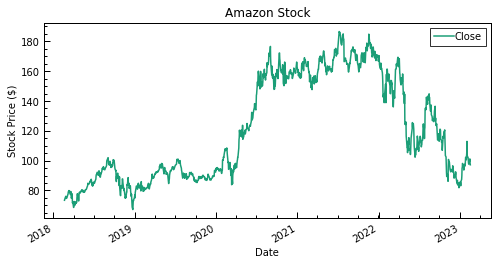

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-02-20 to 2023-02-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB
LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
10
Epoch  10 MSE:  0.1726837009191513
Epoch  20 MSE:  0.015676647424697876
Epoch  30 MSE:  0.013608126901090145
Epoch  40 MSE:  0.01141070481389761
Epoch  50 MSE:  0.008338571526110172
Epoch  60 MSE:  0.00651977164670825
Epoch  70 MSE:  0.005720850080251694
Epoch  80 MSE:  0.005228622816503048
Epoch  90 MSE:  0.004800795577466488


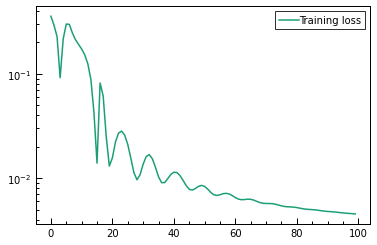

Train Score: 4.03 RMSE
Test Score: 6.31 RMSE


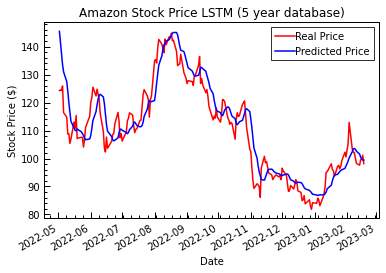

In [81]:
data = yf.download('AMZN', period='5y', interval='1d')

data[['Close']].plot(figsize=(8, 4))
plt.ylabel("Stock Price ($)")
plt.xlabel("Date")
plt.title("Amazon Stock")
plt.show()

close=data[['Close']]
close.info()

close=close.fillna(method='ffill')

# Normalize input values to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
close['Close'] = scaler.fit_transform(close['Close'].values.reshape(-1,1))

look_back = 250 # choose sequence length
x_train, y_train, x_test, y_test = load_data(close, look_back)

# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

# Build model
#####################
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

plt.plot(hist, label="Training loss")
plt.yscale('log')
plt.legend()
plt.show()

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

date_time = close[len(close)-len(y_test):].index

realValues = pd.DataFrame()
realValues['Real Price'] = y_test[:, 0]
realValues = realValues.set_index(date_time)
predictedValues = pd.DataFrame()
predictedValues['Predicted Price'] = y_test_pred[:, 0]
predictedValues = predictedValues.set_index(date_time)

# Visualising the results
figure, axes = plt.subplots()
# plt.plot(realValues, color='red')
# plt.plot(predictedValues, color='blue')
realValues[['Real Price']].plot(color = 'red', ax=axes)
predictedValues[['Predicted Price']].plot(color = 'blue', ax=axes)
#axes.xticks(np.arange(0,394,50))
plt.title('Amazon Stock Price LSTM (5 year database)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.savefig('lstmPredictionLong.png')
plt.show()